In [34]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
from math import sqrt
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import linear_model
from sklearn.metrics import r2_score
import networkx as nx
from networkx.algorithms import bipartite
import itertools

In [36]:
class Experiments(object):
    def __init__(self,
            all_ids,
            ego_followee_dict,
            ego_stat_followee_list,
            unique_dict,
            ratings_dict,
            cq_dict,
            overall_unique_dict,
            wmd_dict,
            process = True):
        
        self.all_ids = all_ids
        self.ego_followee_dict = ego_followee_dict
        self.ego_stat_followee_list = ego_stat_followee_list
        self.unique_dict = unique_dict
        self.ratings_dict = ratings_dict
        self.cq_dict = cq_dict
        self.overall_unique_dict = overall_unique_dict
        self.wmd_dict = wmd_dict
        
        self.alter_followers_dict = {} 
        self.alter_dy_boss = {} 
        self.alter_dy_lost = {} 
        
        if process:
            self.connectivity_update_per_round()
            self.find_popular_alters()
            self.compute_lumped_temporal_boss_vs_lost_uniq()
            self.compute_lumped_boss_vs_lost_ratings()
            self.compute_lumped_temporal_boss_vs_lost_cq()
            self.my_regression("r")
            self.my_regression("ru")
            self.my_regression("all")
            self.my_regression("rq",feature_round=1,output_round=1) #output_round means at the end of that round
            self.my_regression("r",feature_round=1,output_round='final')
            self.stimulation_()
            self.generate_projected_plot("dynamic",True)
            self.compute_similarity_collection(cond_="dynamic")
            self.compute_similarity_collection(cond_="static")
            self.compute_similarity_collection_crowd()
            self.compute_lumped_temporal_cr_vs_st_vs_dy_uniq()
            self.compute_cr_vs_st_vs_dy_rating()
            self.compute_lumped_temporal_cr_vs_st_vs_dy_cq()

            
    def mean_confidence_interval(self,data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h
    
    def compute_adj_r2(self,r2,X,y):
        return 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]) #assuming X already has a column of 1's appended
    
    def full_t_test(self,x1, x2, bonferroni = 1):
        N1 = len(x1)
        N2 = len(x2)
        df = N1+N2-2
        m1 = np.mean(x1)
        m2 = np.mean(x2)
        std1 = np.std(x1)
        std2 = np.std(x2)
        t, p = stats.ttest_ind(x1,x2)
        print('m_1='+str(round(m1,2))+', m_2='+str(round(m2,2))+', t('+str(df)+')='+str(round(t,3))+', p='+str(p)+ ',')
        p_new = p * bonferroni
        print('Bonferroni-corrected (uncorrected p-val * '+str(bonferroni)+') p='+str(p_new))
        from scipy.stats import t
        std_N1N2 = sqrt( ((N1 - 1)*(std1)**2 + (N2 - 1)*(std2)**2) / df) 

        diff_mean = m1 - m2
        MoE = t.ppf(0.975, df) * std_N1N2 * sqrt(1/N1 + 1/N2)
        ind_t_test = stats.ttest_ind(x1,x2)
        print ('95% C.I. for m_1-m_2=[{:3.3f}, {:3.3f}]'.format(diff_mean - MoE, diff_mean + MoE))

            
    def connectivity_update_per_round(self,plot_=False):
        plt.rc('figure', figsize = (18,10))
        print("###### Connectivity updates per ego ######")
        mean_list = []
        for trial_id in range(1,7):
            personal_delta = {2:[],3:[],4:[],5:[],6:[]} 
            for round_ in range(2,7):
                for ego in self.all_ids['ego_dy'][trial_id]:
                    personal_delta[round_].append(len(list(set(self.ego_followee_dict[ego][round_]) - set(self.ego_followee_dict[ego][round_-1]))))

            d=np.array([np.mean(k) for _,k in personal_delta.items()])
            e=np.array([np.std(k) for _,k in personal_delta.items()])    

            m= np.array([self.mean_confidence_interval(k)[0] for _,k in personal_delta.items()])
            l= np.array([self.mean_confidence_interval(k)[1] for _,k in personal_delta.items()])
            h= np.array([self.mean_confidence_interval(k)[2] for _,k in personal_delta.items()])
            
            mean_list.append(list(m))

            plt.subplot(2,3,trial_id);
            plt.plot(range(1,6), m, lw = 2, color = '#7663b0' , alpha = 1, label = 'Mean')
            plt.fill_between(range(1,6), l, h, color ='#7663b0'  , alpha = 0.4, label = 'Std') 
            plt.title("Trial "+str(trial_id))
            plt.xlabel("(At the end of) Round")
            plt.xticks([1,2,3,4,5])
            plt.ylim([-0.4,2])
            plt.ylabel("Connection updates per ego")
            plt.legend(loc = 'best') 
        plt.show()
        print('Avg connection updates per ego at the end of the five rounds: ',np.mean(np.array(mean_list),axis=0))
        
    def find_popular_alters(self):
        self.alter_followers_dict = {}#defaultdict(lambda: [0]*6)
        self.alter_dy_boss = {1:[],2:[],3:[],4:[],5:[],6:[]} #defaultdict(lambda:[])
        self.alter_dy_lost = {1:[],2:[],3:[],4:[],5:[],6:[]} #defaultdict(lambda:[])
        
        for trial_id,ego_list in self.all_ids['ego_dy'].items():
            for ego_ in ego_list:
                for round_ in range(1,7):
                    for alter_ in self.ego_followee_dict[ego_][round_]: #final choices of egos
                        if alter_ not in self.alter_followers_dict:
                            self.alter_followers_dict[alter_]=[0]*6
                        self.alter_followers_dict[alter_][round_-1]+=1
        
        for trial_id,alter_list in self.all_ids['alter_dy'].items():
            pop_list = [alter_ for alter_ in alter_list if self.alter_followers_dict[alter_][-1]>6]
            unpop_list = [alter_ for alter_ in alter_list if self.alter_followers_dict[alter_][-1]<=6]
            self.alter_dy_boss[trial_id].extend(pop_list)
            self.alter_dy_lost[trial_id].extend(unpop_list)
            
        
    def compute_lumped_temporal_boss_vs_lost_uniq(self):
        print("\n\n###### Analysis of popular vs unpopular alters ######\n")
        print("Non-redundant Idea Counts\n")
        plt.rc('figure', figsize = (8,6))
        cc_boss_m=[]
        cc_boss_l=[]
        cc_boss_u=[]
        cc_lost_m=[]
        cc_lost_l=[]
        cc_lost_u=[]

        for round_ in range(1,6):
            boss2 = [np.sum([self.unique_dict[id_][round__][1] for round__ in range(1,round_+1)]) for trial_id in range(1,7) for id_ in self.alter_dy_boss[trial_id]]
            lost2 = [np.sum([self.unique_dict[id_][round__][1] for round__ in range(1,round_+1)]) for trial_id in range(1,7) for id_ in self.alter_dy_lost[trial_id]]

            cc_boss_m.append(self.mean_confidence_interval(boss2)[0])
            cc_boss_l.append(self.mean_confidence_interval(boss2)[1])
            cc_boss_u.append(self.mean_confidence_interval(boss2)[2])
            cc_lost_m.append(self.mean_confidence_interval(lost2)[0])
            cc_lost_l.append(self.mean_confidence_interval(lost2)[1])
            cc_lost_u.append(self.mean_confidence_interval(lost2)[2])

            if round_==5:
                a=np.array(boss2)
                b=np.array(lost2)
                self.full_t_test(a, b)

        h=np.array(cc_boss_m)
        i=np.array(cc_boss_l)
        j=np.array(cc_boss_u)
        k=np.array(cc_lost_m)
        l=np.array(cc_lost_l)
        m=np.array(cc_lost_u)

        _, ax1 = plt.subplots()
        ax1.plot(range(1,6), h, lw = 1, color = '#539caf', alpha = 1, label = 'Popular Mean')
        ax1.fill_between(range(1,6), i, j, color = '#539caf', alpha = 0.4, label = 'Popular 95% CI')
        ax1.plot(range(1,6), k, lw = 1, color = '#7663b0', alpha = 1, label = 'Unpopular Mean')
        ax1.fill_between(range(1,6), l, m, color = '#7663b0', alpha = 0.4, label = 'Unpopular 95% CI')

        ax1.set_title("Cumulative non-redundant ideas")
        ax1.set_xlabel("Round")
        ax1.set_ylabel("Cumulative non-redundant ideas")
        ax1.legend(loc = 'best') 
        plt.xticks([1,2,3,4,5])
        plt.show()

    def compute_lumped_boss_vs_lost_ratings(self):
        print("\nAverage Novelty Ratings\n")
        means=[]
        conf=[]
        boss = [np.mean([np.mean(self.ratings_dict[id_][round_][1]) for round_ in range(1,6)]) for trial_id in range(1,7) for id_ in self.alter_dy_boss[trial_id]]
        lost = [np.mean([np.mean(self.ratings_dict[id_][round_][1]) for round_ in range(1,6)]) for trial_id in range(1,7) for id_ in self.alter_dy_lost[trial_id]]
        a=np.array(boss)
        b=np.array(lost)
        self.full_t_test(a, b)
        print(" ")
        means.append(self.mean_confidence_interval(boss)[0])
        conf.append([self.mean_confidence_interval(boss)[1],self.mean_confidence_interval(boss)[2]])

        means.append(self.mean_confidence_interval(lost)[0])
        conf.append([self.mean_confidence_interval(lost)[1],self.mean_confidence_interval(lost)[2]])

        means=np.array(means)
        conf=np.array(conf)
        yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

        plt.bar(range(len(means)), means, yerr=yerr,color=['#539caf','#7663b0'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
        my_xticks = ['Popular','Unpopular']
        plt.xticks([0,1], my_xticks)
        plt.ylim([1,3.3])
        plt.ylabel('Average Rating')
        plt.show()
        
    def compute_lumped_temporal_boss_vs_lost_cq(self):
        print("\nCreativity Quotient\n")
        plt.rc('figure', figsize = (8,6))

        cc_boss_m=[]
        cc_boss_l=[]
        cc_boss_u=[]
        cc_lost_m=[]
        cc_lost_l=[]
        cc_lost_u=[]

        for round_ in range(1,6):
            boss2 = [np.sum([self.cq_dict[id_][round__][1] for round__ in range(1,round_+1)]) for trial_id in range(1,7) for id_ in self.alter_dy_boss[trial_id]]
            lost2 = [np.sum([self.cq_dict[id_][round__][1] for round__ in range(1,round_+1)]) for trial_id in range(1,7) for id_ in self.alter_dy_lost[trial_id]]

            cc_boss_m.append(self.mean_confidence_interval(boss2)[0])
            cc_boss_l.append(self.mean_confidence_interval(boss2)[1])
            cc_boss_u.append(self.mean_confidence_interval(boss2)[2])
            cc_lost_m.append(self.mean_confidence_interval(lost2)[0])
            cc_lost_l.append(self.mean_confidence_interval(lost2)[1])
            cc_lost_u.append(self.mean_confidence_interval(lost2)[2])

            if round_==5:
                a=np.array(boss2)
                b=np.array(lost2)
                self.full_t_test(a, b)
                print(" ")

        h=np.array(cc_boss_m)
        i=np.array(cc_boss_l)
        j=np.array(cc_boss_u)
        k=np.array(cc_lost_m)
        l=np.array(cc_lost_l)
        m=np.array(cc_lost_u)

        _, ax1 = plt.subplots()
        ax1.plot(range(1,6), h, lw = 1, color = '#539caf', alpha = 1, label = 'Popular Mean')
        ax1.fill_between(range(1,6), i, j, color = '#539caf', alpha = 0.4, label = 'Popular 95% CI')
        ax1.plot(range(1,6), k, lw = 1, color = '#7663b0', alpha = 1, label = 'Unpopular Mean')
        ax1.fill_between(range(1,6), l, m, color = '#7663b0', alpha = 0.4, label = 'Unpopular 95% CI')

        ax1.set_title("Cumulative Q")
        ax1.set_xlabel("Round")
        ax1.set_ylabel("Cumulative Q")
        ax1.legend(loc = 'best') 
        plt.xticks([1,2,3,4,5])
        plt.show()     


    def my_regression_prep(self,feature_round='all',output_round="final"):
        alter_regr_dict={}
        # populate y
        for key,value in self.alter_followers_dict.items():
            if output_round=="final":
                alter_regr_dict[key]={'y_prime':value[-1]/18.,'u_prime':0.,'r_prime':0.,'q_prime':0.}
            else:
                alter_regr_dict[key]={'y_prime':value[output_round]/18.,'u_prime':0.,'r_prime':0.,'q_prime':0.}
        
        # populate u, r and q
        for trial_id in range(1,7):
            if feature_round=='all':
                tot_ideas_in_trial = np.sum([self.unique_dict[id_]['total'] for id_ in self.all_ids['alter_dy'][trial_id]])
                tot_ratings_in_trial = np.sum([np.mean([np.mean(self.ratings_dict[id_][round_][1]) for round_ in range(1,6)]) for id_ in self.all_ids['alter_dy'][trial_id]])
                tot_cq_in_trial = np.sum([self.cq_dict[id_]['all']['both']  for id_ in self.all_ids['alter_dy'][trial_id]])
            else:
                tot_ideas_in_trial = np.sum([self.unique_dict[id_][feature_round][1] for id_ in self.all_ids['alter_dy'][trial_id]])
                tot_ratings_in_trial = np.sum([np.mean([np.mean(self.ratings_dict[id_][round_][1]) for round_ in range(1,feature_round+1)]) for id_ in self.all_ids['alter_dy'][trial_id]])
                tot_cq_in_trial = np.sum([self.cq_dict[id_][feature_round][1]  for id_ in self.all_ids['alter_dy'][trial_id]])
            
            
            for id_ in self.all_ids['alter_dy'][trial_id]:
                if feature_round=='all':
                    alter_regr_dict[id_]['u_prime'] = self.unique_dict[id_]['total']/float(tot_ideas_in_trial)
                    alter_regr_dict[id_]['r_prime'] = np.mean([np.mean(self.ratings_dict[id_][round_][1]) for round_ in range(1,6)])/float(tot_ratings_in_trial)
                    alter_regr_dict[id_]['q_prime'] = self.cq_dict[id_]['all']['both']/float(tot_cq_in_trial)
                else:
                    alter_regr_dict[id_]['u_prime'] = self.unique_dict[id_][feature_round][1]/float(tot_ideas_in_trial)
                    alter_regr_dict[id_]['r_prime'] = np.mean([np.mean(self.ratings_dict[id_][round_][1]) for round_ in range(1,feature_round+1)])/float(tot_ratings_in_trial)
                    alter_regr_dict[id_]['q_prime'] = self.cq_dict[id_][feature_round][1]/float(tot_cq_in_trial)

        return alter_regr_dict

    
    def my_regression_generateXY(self, choice="all",feature_round="all",output_round="final"):
        info_dict = self.my_regression_prep(feature_round,output_round)
        x_up = []
        x_rp = []
        x_qp = []
        y_p = []

        for trial_id,trial_list in self.all_ids['alter_dy'].items():
            for alter_ in trial_list:
                y_p.append(info_dict[alter_]['y_prime'])
                x_up.append(info_dict[alter_]['u_prime'])
                x_rp.append(info_dict[alter_]['r_prime'])
                x_qp.append(info_dict[alter_]['q_prime'])

        X_p_u = np.array(x_up)
        X_p_r = np.array(x_rp)
        X_p_q = np.array(x_qp)
        X_p_ru = np.column_stack((np.array(x_rp),np.array(x_up)))
        X_p_uq = np.column_stack((np.array(x_up),np.array(x_qp)))
        X_p_rq = np.column_stack((np.array(x_rp),np.array(x_qp)))
        X_p_ruq = np.column_stack((np.array(x_rp),np.array(x_up),np.array(x_qp)))
        y_p = np.array(y_p)

        X_p_ruq = stats.zscore(X_p_ruq, axis=0)
        X_p_u = stats.zscore(X_p_u, axis=0)
        X_p_r = stats.zscore(X_p_r, axis=0)
        X_p_q = stats.zscore(X_p_q, axis=0)
        X_p_ru = stats.zscore(X_p_ru, axis=0)
        X_p_uq = stats.zscore(X_p_uq, axis=0)
        X_p_rq = stats.zscore(X_p_rq, axis=0)

        X_p_u = sm.add_constant(X_p_u)
        X_p_r = sm.add_constant(X_p_r)
        X_p_q = sm.add_constant(X_p_q)
        X_p_ru = sm.add_constant(X_p_ru)
        X_p_uq = sm.add_constant(X_p_uq)
        X_p_rq = sm.add_constant(X_p_rq)
        X_p_ruq = sm.add_constant(X_p_ruq)

        if choice=='all':
            X_chosen = X_p_ruq
        if choice=='r':
            X_chosen = X_p_r
        if choice=='u':
            X_chosen = X_p_u
        if choice=='q':
            X_chosen = X_p_q
        if choice=='ru':
            X_chosen = X_p_ru
        if choice=='uq':
            X_chosen = X_p_uq
        if choice=='rq':
            X_chosen = X_p_rq
        
        return y_p, X_chosen
    
   
    def compute_bootstrapped_R2(self,X,y):
        df = pd.DataFrame(data=X)
        df['y'] = y
        df['y_label'] = (y*18>6)*1

        r2_list = []
        r2_list_adj = []

        split = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=1234) 
        for train_index, test_index in split.split(df, df['y_label']):
            strat_train_set = df.loc[train_index]
            strat_test_set = df.loc[test_index]

            for set in (strat_train_set, strat_test_set):
                set.drop(["y_label"], axis=1, inplace=True)

            X_train = strat_train_set.drop("y", axis=1)
            y_train = strat_train_set["y"].copy()
            X_test = strat_test_set.drop("y", axis=1)
            y_test = strat_test_set["y"].copy()

            # sklearn
            lm = linear_model.LinearRegression()
            model = lm.fit(X_train, y_train)
            y_pred = lm.predict(X_test)
            r_squared = r2_score(y_test, y_pred)
            r2_list.append(r_squared)

            adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1])

            r2_list_adj.append(adjusted_r_squared)

        print('\nR2: ',self.mean_confidence_interval(r2_list)[0],' 95% CI=[',str(self.mean_confidence_interval(r2_list)[1]),',',str(self.mean_confidence_interval(r2_list)[2]),']')
        print('adj-R2: ',self.mean_confidence_interval(r2_list_adj)[0],' 95% CI=[',str(self.mean_confidence_interval(r2_list_adj)[1]),',',str(self.mean_confidence_interval(r2_list_adj)[2]),']')

    
    def my_regression(self, choice='all',feature_round="all",output_round="final"):
        print("\n\n###### Link update regressions ######\n")
        print("Using metrics: "+str(choice)+", input features from rounds: "+str(feature_round)+", target variable after round: "+str(output_round)+"\n")
        
        y_p, X_chosen = self.my_regression_generateXY(choice,feature_round,output_round)
        
        model = sm.OLS(y_p, X_chosen).fit()
        print(model.summary())
        self.compute_bootstrapped_R2(X_chosen,y_p)
        
    
    def stimulation_(self):
        print("\n\n###### Exposure to high-performing alters is associated with better performance of egos ######\n")
        print("Please refer to the attached R code file. \n")
    
    
    def compute_lumped_temporal_cr_vs_st_vs_dy_uniq(self):
        print("\n\n###### Individual creative performance comparisons ######\n")
        print("Non-redundant idea counts\n")
        plt.rc('figure', figsize = (8,6))
        means_s=[]
        conf_s=[]
        means_d=[]
        conf_d=[]
        means_c=[]
        conf_c=[]
        for round_ in range(1,6):
            static_list = [np.sum([self.overall_unique_dict[id_][round__][1]+self.overall_unique_dict[id_][round__][2] for round__ in range(1,round_+1)]) for trial_id in self.all_ids['ego_stat'] for id_ in self.all_ids['ego_stat'][trial_id]]
            dynamic_list = [np.sum([self.overall_unique_dict[id_][round__][1]+self.overall_unique_dict[id_][round__][2] for round__ in range(1,round_+1)]) for trial_id in self.all_ids['ego_dy'] for id_ in self.all_ids['ego_dy'][trial_id]]
            crowd_list = [np.sum([self.overall_unique_dict[id_][round__][1]+self.overall_unique_dict[id_][round__][2] for round__ in range(1,round_+1)]) for trial_id in self.all_ids['crowd'] for id_ in self.all_ids['crowd'][trial_id]]      

            means_s.append(self.mean_confidence_interval(static_list)[0])
            conf_s.append([self.mean_confidence_interval(static_list)[1],self.mean_confidence_interval(static_list)[2]])

            means_d.append(self.mean_confidence_interval(dynamic_list)[0])
            conf_d.append([self.mean_confidence_interval(dynamic_list)[1],self.mean_confidence_interval(dynamic_list)[2]])

            means_c.append(self.mean_confidence_interval(crowd_list)[0])
            conf_c.append([self.mean_confidence_interval(crowd_list)[1],self.mean_confidence_interval(crowd_list)[2]])

            if round_==5:
                aa=np.array(crowd_list)
                bb=np.array(dynamic_list)
                print("dynamic - crowd")
                self.full_t_test(bb,aa,3)
                print(" ")
                aa=np.array(crowd_list)
                bb=np.array(static_list)
                print("static - crowd")
                self.full_t_test(bb,aa,3)
                print(" ")
                aa=np.array(dynamic_list)
                bb=np.array(static_list)
                print("dynamic - static")
                self.full_t_test(aa,bb,3)
                print(" ")

        means_s=np.array(means_s)
        means_d=np.array(means_d)
        means_c=np.array(means_c)
        conf_s=np.array(conf_s)
        conf_d=np.array(conf_d)
        conf_c=np.array(conf_c)
        yerr_s = np.c_[means_s-conf_s[:,0],conf_s[:,1]-means_s ].T
        yerr_d = np.c_[means_d-conf_d[:,0],conf_d[:,1]-means_d ].T
        yerr_c = np.c_[means_c-conf_c[:,0],conf_c[:,1]-means_c ].T

        _, ax1 = plt.subplots()
        ax1.errorbar(range(len(means_s)), means_s, yerr=yerr_s, color = '#539caf',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Static')
        ax1.errorbar(range(len(means_d)), means_d, yerr=yerr_d, color = '#7663b0',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Dynamic')
        ax1.errorbar(range(len(means_c)), means_c, yerr=yerr_c, color = '#EA9193',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Solo')

        ax1.set_title("Cumulative non-redundant ideas")
        ax1.set_xlabel("Round")
        ax1.set_ylabel("Cumulative non-redundant ideas")
        ax1.legend(loc = 'upper left')
        plt.xticks([0,1,2,3,4],[1,2,3,4,5])
        plt.show() 


    def compute_cr_vs_st_vs_dy_rating(self):
        print("\nAverage Novelty Ratings\n")
        plt.rc('figure', figsize = (8,6))
        means=[]
        conf=[]
        static_list = [np.mean([r for round_ in range(1,6) for r in self.ratings_dict[id_][round_][1]+self.ratings_dict[id_][round_][2]]) for trial_id in self.all_ids['ego_stat'] for id_ in self.all_ids['ego_stat'][trial_id]]
        dynamic_list = [np.mean([r for round_ in range(1,6) for r in self.ratings_dict[id_][round_][1]+self.ratings_dict[id_][round_][2]]) for trial_id in self.all_ids['ego_dy'] for id_ in self.all_ids['ego_dy'][trial_id]]
        crowd_list = [np.mean([r for round_ in range(1,6) for r in self.ratings_dict[id_][round_][1]+self.ratings_dict[id_][round_][2]]) for trial_id in self.all_ids['crowd'] for id_ in self.all_ids['crowd'][trial_id]]

        a=np.array(crowd_list)
        b=np.array(dynamic_list)
        c=np.array(static_list)
        print("crowd - dynamic")
        self.full_t_test(a,b,3)
        print(" ")
        print("dynamic - static")
        self.full_t_test(b,c,3)
        print(" ")
        print("static - crowd")
        self.full_t_test(c,a,3)
        print(" ")

        means.append(self.mean_confidence_interval(static_list)[0])
        conf.append([self.mean_confidence_interval(static_list)[1],self.mean_confidence_interval(static_list)[2]])

        means.append(self.mean_confidence_interval(dynamic_list)[0])
        conf.append([self.mean_confidence_interval(dynamic_list)[1],self.mean_confidence_interval(dynamic_list)[2]])

        means.append(self.mean_confidence_interval(crowd_list)[0])
        conf.append([self.mean_confidence_interval(crowd_list)[1],self.mean_confidence_interval(crowd_list)[2]])

        means=np.array(means)
        conf=np.array(conf)
        yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

        plt.bar(range(len(means)), means, yerr=yerr,color=['#539caf','#7663b0','#EA9193'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
        my_xticks = ['Static','Dynamic','Solo']
        plt.xticks([0,1,2], my_xticks)
        plt.ylabel('Average rating')
        plt.ylim([2.6,3.2])
        plt.show()

    def compute_lumped_temporal_cr_vs_st_vs_dy_cq(self):
        print("\nCreativity Quotient\n")
        plt.rc('figure', figsize = (8,6))
        means_s=[]
        conf_s=[]    
        means_d=[]
        conf_d=[]
        means_c=[]
        conf_c=[]
        for round_ in range(1,6):
            static_list = [np.sum([self.cq_dict[id_][round__]['both'] for round__ in range(1,round_+1)]) for trial_id in self.all_ids['ego_stat'] for id_ in self.all_ids['ego_stat'][trial_id]]
            dynamic_list = [np.sum([self.cq_dict[id_][round__]['both'] for round__ in range(1,round_+1)]) for trial_id in self.all_ids['ego_dy'] for id_ in self.all_ids['ego_dy'][trial_id]]
            crowd_list = [np.sum([self.cq_dict[id_][round__]['both'] for round__ in range(1,round_+1)]) for trial_id in self.all_ids['crowd'] for id_ in self.all_ids['crowd'][trial_id]]

            means_s.append(self.mean_confidence_interval(static_list)[0])
            conf_s.append([self.mean_confidence_interval(static_list)[1],self.mean_confidence_interval(static_list)[2]])

            means_d.append(self.mean_confidence_interval(dynamic_list)[0])
            conf_d.append([self.mean_confidence_interval(dynamic_list)[1],self.mean_confidence_interval(dynamic_list)[2]])

            means_c.append(self.mean_confidence_interval(crowd_list)[0])
            conf_c.append([self.mean_confidence_interval(crowd_list)[1],self.mean_confidence_interval(crowd_list)[2]])

            if round_==5:
                aa=np.array(crowd_list)
                bb=np.array(dynamic_list)
                print("dynamic - crowd")
                self.full_t_test(bb,aa,3)
                print(" ")
                aa=np.array(crowd_list)
                bb=np.array(static_list)
                print("static - crowd")
                self.full_t_test(bb,aa,3)
                print(" ")
                aa=np.array(dynamic_list)
                bb=np.array(static_list)
                print("dynamic - static")
                self.full_t_test(aa,bb,3)
                print(" ")

        means_s=np.array(means_s)
        means_d=np.array(means_d)
        means_c=np.array(means_c)
        conf_s=np.array(conf_s)
        conf_d=np.array(conf_d)
        conf_c=np.array(conf_c)
        yerr_s = np.c_[means_s-conf_s[:,0],conf_s[:,1]-means_s ].T
        yerr_d = np.c_[means_d-conf_d[:,0],conf_d[:,1]-means_d ].T
        yerr_c = np.c_[means_c-conf_c[:,0],conf_c[:,1]-means_c ].T

        _, ax1 = plt.subplots()
        ax1.errorbar(range(len(means_s)), means_s, yerr=yerr_s, color = '#539caf',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Static')
        ax1.errorbar(range(len(means_d)), means_d, yerr=yerr_d, color = '#7663b0',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Dynamic')
        ax1.errorbar(range(len(means_c)), means_c, yerr=yerr_c, color = '#EA9193',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Solo')

        ax1.set_title("Cumulative Creativity Quotient")
        ax1.set_xlabel("Round")
        ax1.set_ylabel("Cumulative Q")
        ax1.legend(loc = 'upper left')
        plt.xticks([0,1,2,3,4],[1,2,3,4,5])
        plt.show()

    def generate_adjacency(self, cond_="dynamic"):
        adjacency_dict={}
        for trial_id in range(1,7):
            my_adjacency = np.zeros((6,18,6))
            ego_ids = self.all_ids['ego_dy'][trial_id] if cond_=="dynamic" else self.all_ids['ego_stat'][trial_id]
            alter_ids = self.all_ids['alter_dy'][trial_id] if cond_=="dynamic" else self.all_ids['alter_stat'][trial_id]
            
            for ego_id in ego_ids:
                for round_ in range(1,7):
                    id_l = self.ego_followee_dict[ego_id][round_] if cond_=="dynamic" else self.ego_stat_followee_list[ego_id]
                    for alter_id in id_l:
                        ego_index = ego_ids.index(ego_id)
                        alter_index = alter_ids.index(alter_id)
                        my_adjacency[alter_index,ego_index,round_-1]+=1

            adjacency_dict[trial_id] = my_adjacency
        return adjacency_dict
    

    
    def generate_projected_plot(self,cond_="dynamic",plot_=None):
        adjacency_dict = self.generate_adjacency(cond_)
        ego_index = [i for i in range(6,24)]

        projected_dict={}
        for trial_id in adjacency_dict:
            projected_dict[trial_id]={}
            if plot_:
                print("###### Projected plots ######\n")
                plt.rc('figure', figsize = (18,12))
            for round_id in range(0,6):
                if plot_:
                    plt.subplot(2,3,round_id+1);
                a = adjacency_dict[trial_id][:,:,round_id]
                p = np.hstack((np.zeros((6,6)),a))
                q = np.hstack((np.transpose(a),(np.zeros((18,18)))))
                A = np.vstack((p,q))
                G = nx.from_numpy_matrix(A)
                proj = bipartite.weighted_projected_graph(G,ego_index)
                mapping={}
                for index, i in enumerate(range(6,24)):
                    mapping[i]=self.all_ids['ego_dy'][trial_id][index] if cond_=="dynamic" else self.all_ids['ego_stat'][trial_id][index]

                proj=nx.relabel_nodes(proj,mapping)

                projected_dict[trial_id][round_id]=proj

                if plot_:
                    if round_id==0:
                        
                        print("Condtion: "+str(cond_)+", Trial: "+str(trial_id))
                    pos=nx.spring_layout(proj) 
                    nx.draw_networkx_nodes(proj,pos,label=ego_index)
                    nx.draw_networkx_labels(proj,pos,label=ego_index)

                    all_weights = []
                    for (node1,node2,data) in proj.edges(data=True):
                        all_weights.append(data['weight'])

                    unique_weights = list(set(all_weights))
                    edge_color_set = ['c','m']
                    for weight in unique_weights:
                        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in proj.edges(data=True) if edge_attr['weight']==weight]
                        width = weight*18*5.0/sum(all_weights)
                        nx.draw_networkx_edges(proj,pos,edgelist=weighted_edges,width=width,edge_color=edge_color_set[weight-1])
                    plt.axis('off')
                    plt.title('Round: '+str(round_id))
            if plot_:
                plt.savefig("plots/trial_dynamic_"+str(trial_id)+".eps") 
                plt.show()
        return projected_dict       
    
    def plot_dy_st(self,collection_similarity):
        plt.rc('figure', figsize = (8,6))
        means_s0=[]
        means_s1=[]
        means_s2=[]
        conf_s0=[]
        conf_s1=[]
        conf_s2=[]

        for round_id in range(1,6):
            s0 = [i for trial_id in collection_similarity for i in collection_similarity[trial_id][round_id]['sim0']]
            s1 = [i for trial_id in collection_similarity for i in collection_similarity[trial_id][round_id]['sim1']]
            s2 = [i for trial_id in collection_similarity for i in collection_similarity[trial_id][round_id]['sim2']]
            if round_id==5:
                a0=np.array(s0)
                a1=np.array(s1)
                a2=np.array(s2)
                print("s2-s0")
                self.full_t_test(a2,a0,3)
                print(" ")
                print("s2-s1")
                self.full_t_test(a2,a1,3)
                print(" ")
            means_s0.append(self.mean_confidence_interval(s0)[0])
            conf_s0.append([self.mean_confidence_interval(s0)[1],self.mean_confidence_interval(s0)[2]])

            means_s1.append(self.mean_confidence_interval(s1)[0])
            conf_s1.append([self.mean_confidence_interval(s1)[1],self.mean_confidence_interval(s1)[2]])

            means_s2.append(self.mean_confidence_interval(s2)[0])
            conf_s2.append([self.mean_confidence_interval(s2)[1],self.mean_confidence_interval(s2)[2]])

        means_s0=np.array(means_s0)
        means_s1=np.array(means_s1)
        means_s2=np.array(means_s2)
        conf_s0=np.array(conf_s0)
        conf_s1=np.array(conf_s1)
        conf_s2=np.array(conf_s2)
        yerr_s0 = np.c_[means_s0-conf_s0[:,0],conf_s0[:,1]-means_s0 ].T
        yerr_s1 = np.c_[means_s1-conf_s1[:,0],conf_s1[:,1]-means_s1 ].T
        yerr_s2 = np.c_[means_s2-conf_s2[:,0],conf_s2[:,1]-means_s2 ].T
        plt.errorbar(range(len(means_s0)), means_s0, yerr=yerr_s0, color = '#539caf',fmt='-',capsize=4,elinewidth=2,lw=4,label = '0 common alter')
        plt.errorbar(range(len(means_s1)), means_s1, yerr=yerr_s1, color = '#7663b0',fmt='-',capsize=4,elinewidth=2,lw=4,label = '1 common alter')
        plt.errorbar(range(len(means_s2)), means_s2, yerr=yerr_s2, color = '#EA9193',fmt='-',capsize=4,elinewidth=2,lw=4,label = '2 common alters')
        plt.legend(loc = 'upper right')
        plt.ylim([2.8,3.6])
        plt.xticks([0,1,2,3,4],[1,2,3,4,5])
        plt.xlabel("Round")
        plt.ylabel("Word Mover's Distance")
        plt.show()
   
    
    def compute_similarity_collection(self,cond_="dynamic"):
        print("\n###### Compute inter-ego similarity ######\n")
        print(cond_,"\n")
        collection_similarity = {}
        projected_dict = self.generate_projected_plot(cond_,None)

        for trial_id in range(1,7):
            collection_similarity[trial_id]={}
            for round_id in range(1,6): #round 0's (init) network structure used in round 1, etc, so round 5's end structure is never used
                collection_similarity[trial_id][round_id]={'sim0':[],'sim1':[],'sim2':[]}
                temp_graph = projected_dict[trial_id][round_id-1]
                nodes_list = list(temp_graph.nodes())
                edges_list = list(temp_graph.edges(data=False))
                for n1,n2,w in list(temp_graph.edges(data=True)):
                    #wmd = compute_wmd_distance2(n1,n2,round_id,comp)
                    wmd = self.wmd_dict[(n1,n2,round_id)]
                    if w['weight']==1:
                        collection_similarity[trial_id][round_id]['sim1'].append(wmd)
                    if w['weight']==2:
                        collection_similarity[trial_id][round_id]['sim2'].append(wmd)

                for t1,t2 in list(itertools.combinations(nodes_list, 2)): #iterate over all possible edges
                    if (t1,t2) not in edges_list and (t2,t1) not in edges_list: #this is a weight 0 or 'missing' edge
                        #wmd = compute_wmd_distance2(t1,t2,round_id,comp)
                        wmd = self.wmd_dict[(t1,t2,round_id)]
                        collection_similarity[trial_id][round_id]['sim0'].append(wmd)

        self.plot_dy_st(collection_similarity) 

    def compute_similarity_collection_crowd(self):
        print("\nSolo\n")
        collection_similarity = {}
        all_crowd_ids = [i for group in self.all_ids['crowd'] for i in self.all_ids['crowd'][group]]

        for round_id in range(1,6): #round 0's (init) network structure used in round 1, etc, so round 5's end structure is never used
            collection_similarity[round_id]={'sim0':[],'sim1':[],'sim2':[]}
            for n1,n2 in itertools.combinations(all_crowd_ids,2):
                #wmd = compute_wmd_distance3(n1,n2,round_id,comp)
                wmd = self.wmd_dict[(n1,n2,round_id)]
                collection_similarity[round_id]['sim0'].append(wmd)
        plt.rc('figure', figsize = (8,6))
        means_s0=[]
        means_s1=[]
        means_s2=[]
        conf_s0=[]
        conf_s1=[]
        conf_s2=[]

        for round_id in range(1,6):
            s0 = [i  for i in collection_similarity[round_id]['sim0']]
            means_s0.append(self.mean_confidence_interval(s0)[0])
            conf_s0.append([self.mean_confidence_interval(s0)[1],self.mean_confidence_interval(s0)[2]]) 
        means_s0=np.array(means_s0)
        conf_s0=np.array(conf_s0)
        yerr_s0 = np.c_[means_s0-conf_s0[:,0],conf_s0[:,1]-means_s0 ].T

        plt.errorbar(range(len(means_s0)), means_s0, yerr=yerr_s0, color = '#539caf',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'solo')
        plt.legend(loc = 'upper left')
        plt.ylim([2.8,3.6])
        plt.xticks([0,1,2,3,4],[1,2,3,4,5])
        plt.xlabel("Round")
        plt.ylabel("Word Mover's Distance")
        plt.show()

###### Connectivity updates per ego ######


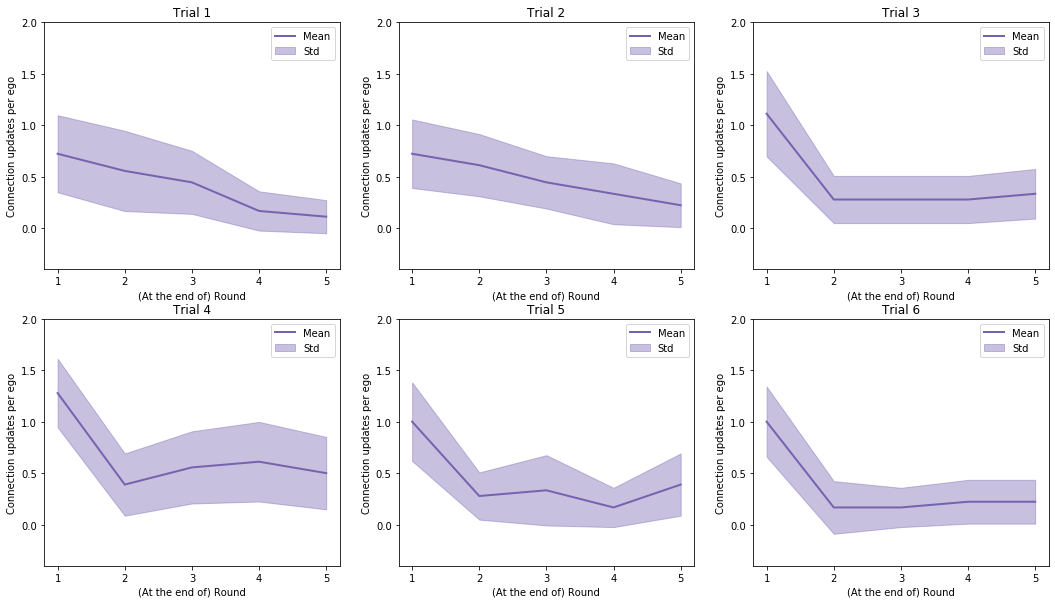

Avg connection updates per ego at the end of the five rounds:  [0.97222222 0.37962963 0.37037037 0.2962963  0.2962963 ]


###### Analysis of popular vs unpopular alters ######

Non-redundant Idea Counts

m_1=23.77, m_2=14.35, t(34)=7.291, p=1.9178728586931627e-08,
Bonferroni-corrected (uncorrected p-val * 1) p=1.9178728586931627e-08
95% C.I. for m_1-m_2=[6.871, 11.972]


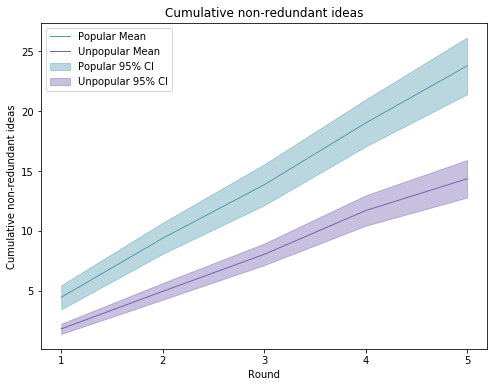


Average Novelty Ratings

m_1=3.05, m_2=2.64, t(34)=5.699, p=2.1168677303637253e-06,
Bonferroni-corrected (uncorrected p-val * 1) p=2.1168677303637253e-06
95% C.I. for m_1-m_2=[0.272, 0.562]
 


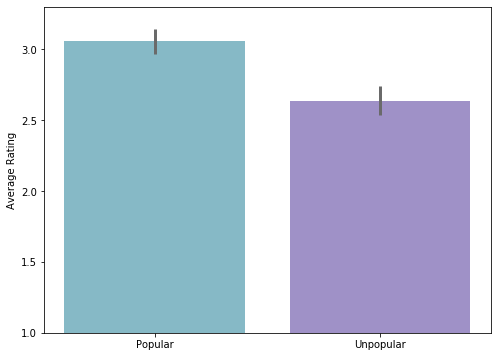


Creativity Quotient

m_1=57.77, m_2=36.74, t(34)=5.806, p=1.537941425062231e-06,
Bonferroni-corrected (uncorrected p-val * 1) p=1.537941425062231e-06
95% C.I. for m_1-m_2=[13.895, 28.160]
 


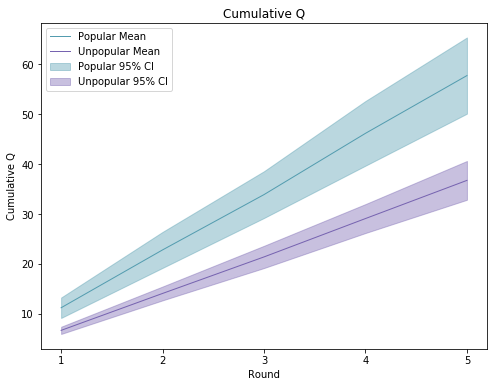



###### Link update regressions ######

Using metrics: r, input features from rounds: all, target variable after round: final

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     95.29
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           2.16e-11
Time:                        10:24:39   Log-Likelihood:                 28.203
No. Observations:                  36   AIC:                            -52.41
Df Residuals:                      34   BIC:                            -49.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

R2:  0.7383983020772775  95% CI=[ 0.669792814828787 , 0.807003789325768 ]
adj-R2:  0.6729978775965969  95% CI=[ 0.5872410185359838 , 0.75875473665721 ]


###### Link update regressions ######

Using metrics: r, input features from rounds: 1, target variable after round: final

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     60.95
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           4.37e-09
Time:                        10:24:40   Log-Likelihood:                 22.647
No. Observations:                  36   AIC:                            -41.29
Df Residuals:                      34   BIC:                            -38.

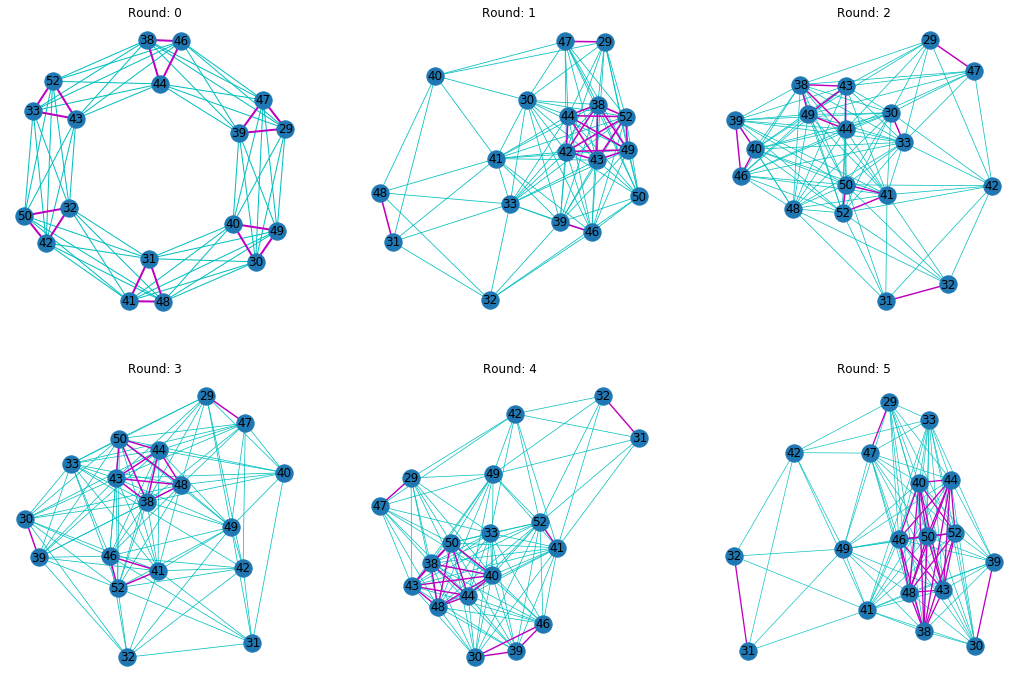

###### Projected plots ######

Condtion: dynamic, Trial: 2


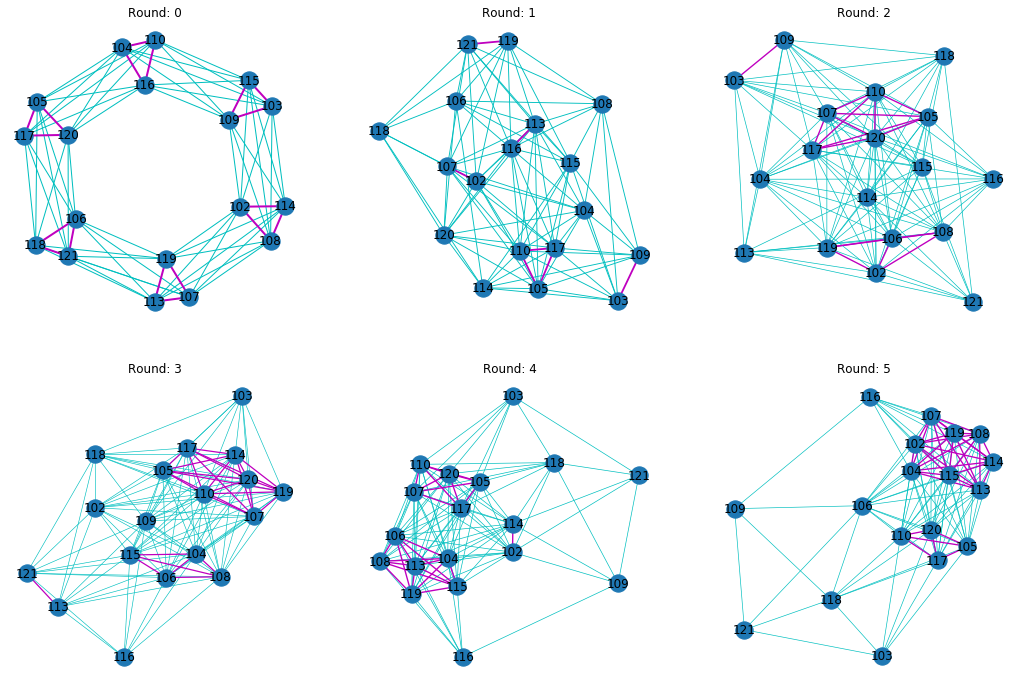

###### Projected plots ######

Condtion: dynamic, Trial: 3


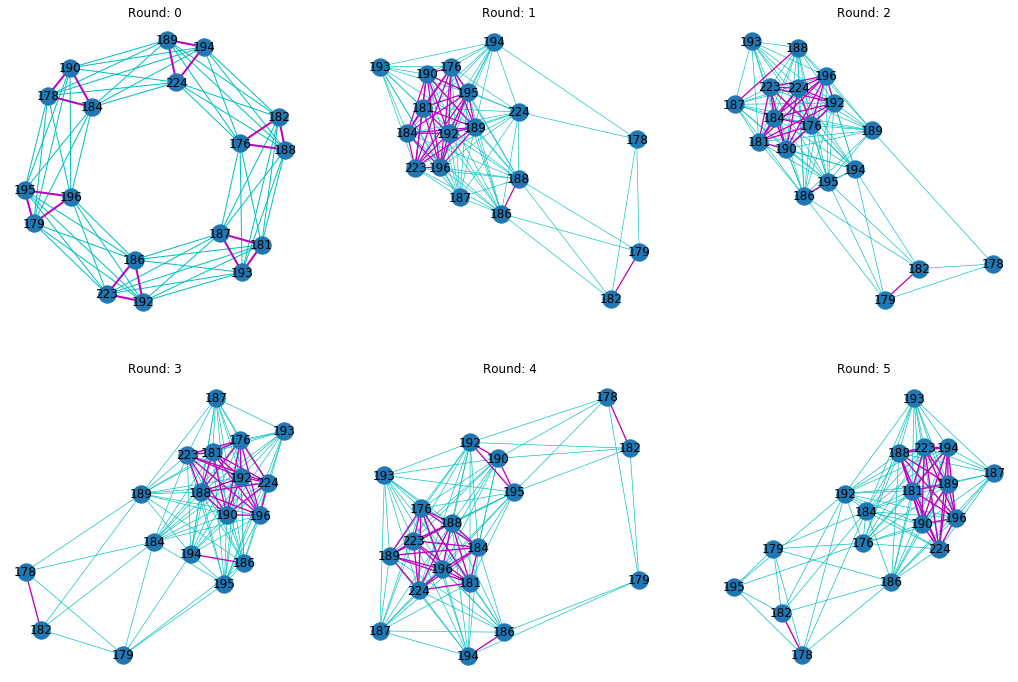

###### Projected plots ######

Condtion: dynamic, Trial: 4


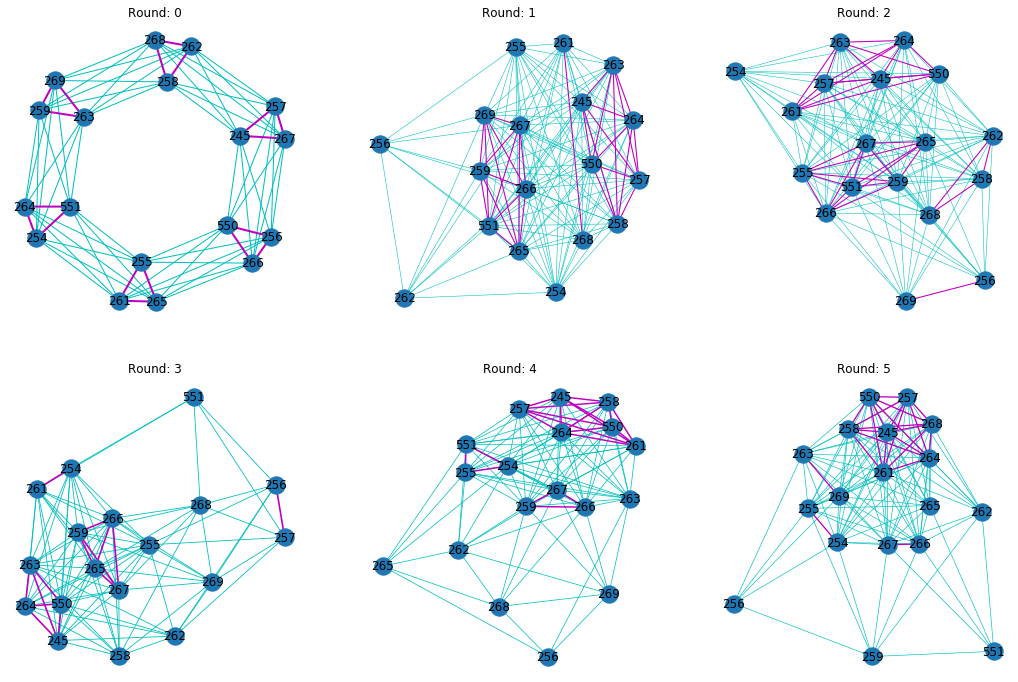

###### Projected plots ######

Condtion: dynamic, Trial: 5


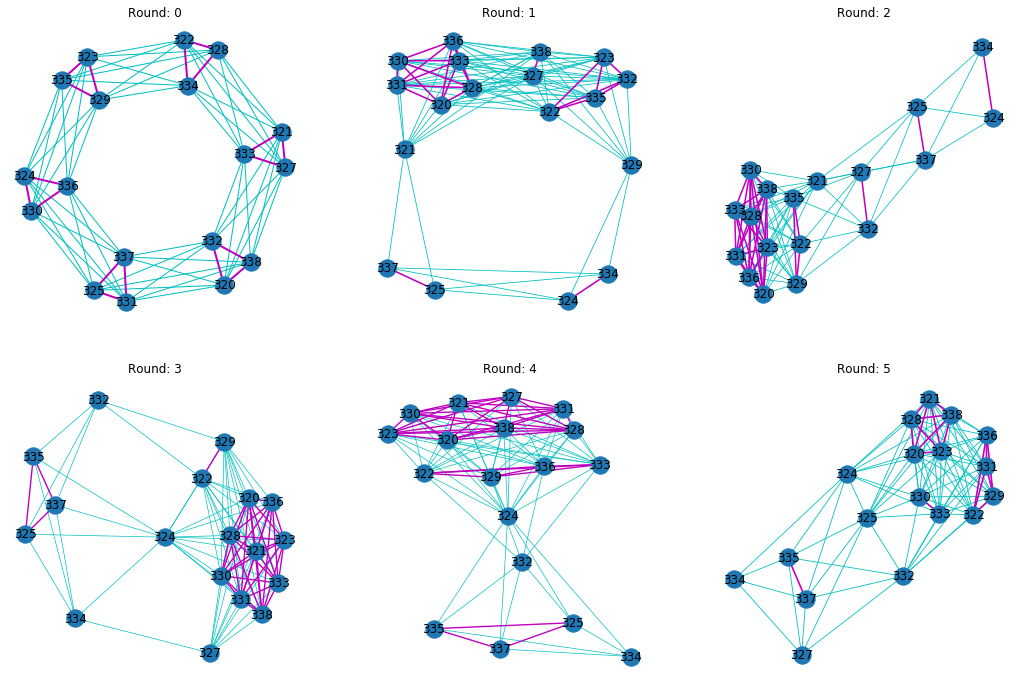

###### Projected plots ######

Condtion: dynamic, Trial: 6


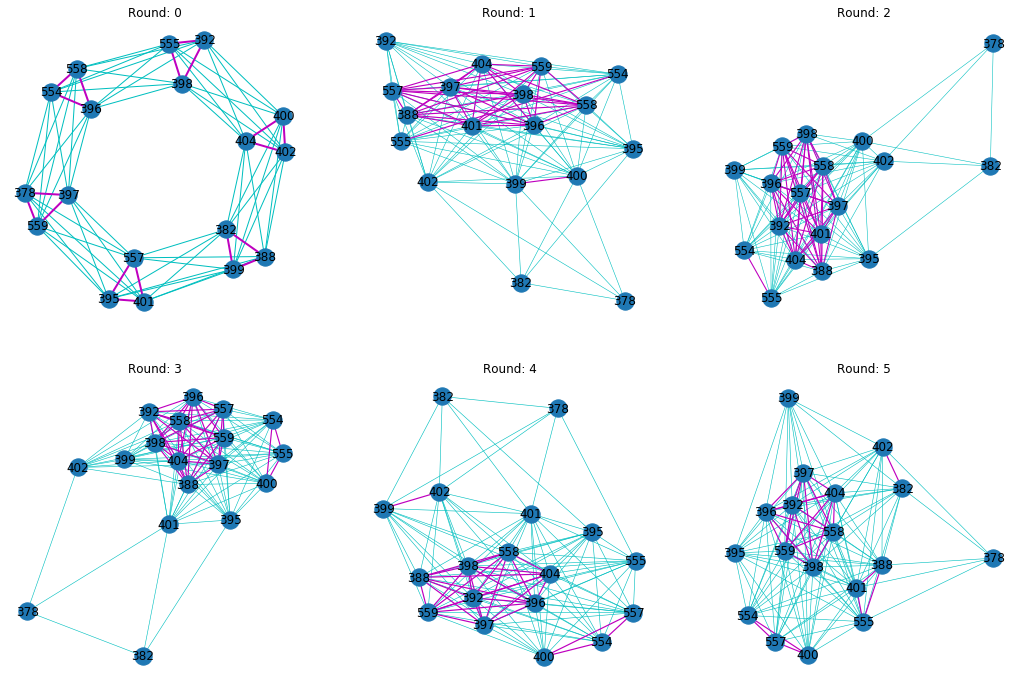


###### Compute inter-ego similarity ######

dynamic 

s2-s0
m_1=3.01, m_2=3.22, t(452)=-2.962, p=0.003217269459769723,
Bonferroni-corrected (uncorrected p-val * 3) p=0.009651808379309169
95% C.I. for m_1-m_2=[-0.360, -0.073]
 
s2-s1
m_1=3.01, m_2=3.19, t(632)=-2.788, p=0.005467491113007128,
Bonferroni-corrected (uncorrected p-val * 3) p=0.01640247333902138
95% C.I. for m_1-m_2=[-0.309, -0.054]
 


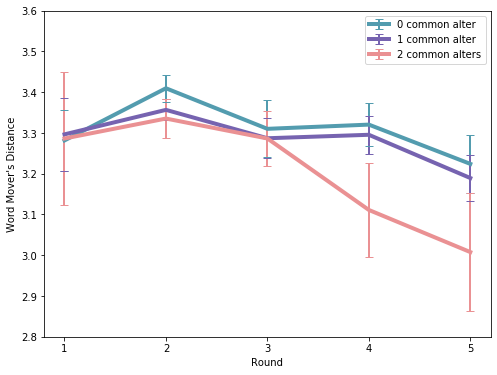


###### Compute inter-ego similarity ######

static 

s2-s0
m_1=3.23, m_2=3.26, t(592)=-0.611, p=0.5411309656278201,
Bonferroni-corrected (uncorrected p-val * 3) p=1.6233928968834603
95% C.I. for m_1-m_2=[-0.149, 0.078]
 
s2-s1
m_1=3.23, m_2=3.26, t(430)=-0.562, p=0.5743402642785866,
Bonferroni-corrected (uncorrected p-val * 3) p=1.72302079283576
95% C.I. for m_1-m_2=[-0.150, 0.083]
 


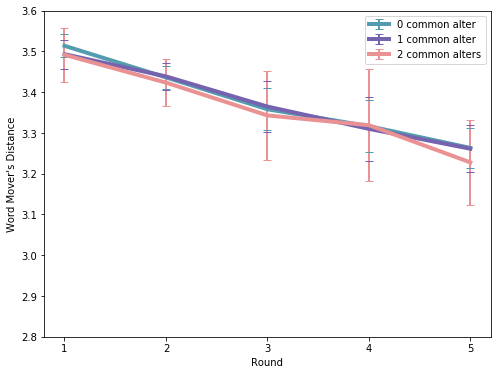


Solo



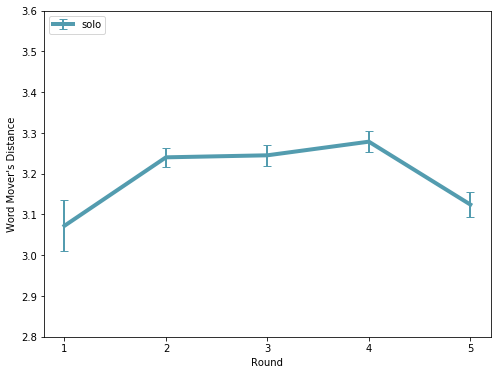



###### Individual creative performance comparisons ######

Non-redundant idea counts

dynamic - crowd
m_1=6.33, m_2=4.44, t(142)=2.7, p=0.00778382525447493,
Bonferroni-corrected (uncorrected p-val * 3) p=0.023351475763424792
95% C.I. for m_1-m_2=[0.515, 3.263]
 
static - crowd
m_1=6.77, m_2=4.44, t(142)=2.898, p=0.004354188361922472,
Bonferroni-corrected (uncorrected p-val * 3) p=0.013062565085767416
95% C.I. for m_1-m_2=[0.749, 3.899]
 
dynamic - static
m_1=6.33, m_2=6.77, t(214)=-0.795, p=0.42739171047643376,
Bonferroni-corrected (uncorrected p-val * 3) p=1.2821751314293013
95% C.I. for m_1-m_2=[-1.509, 0.639]
 


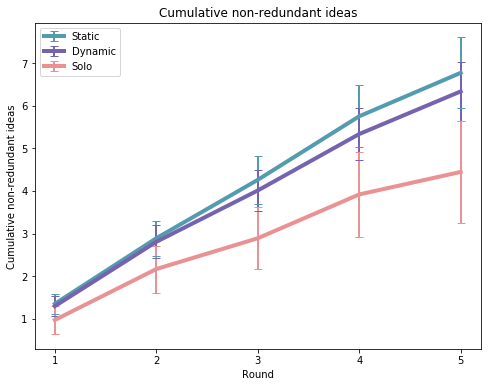


Average Novelty Ratings

crowd - dynamic
m_1=3.06, m_2=3.09, t(142)=-0.692, p=0.49014969255829177,
Bonferroni-corrected (uncorrected p-val * 3) p=1.4704490776748753
95% C.I. for m_1-m_2=[-0.108, 0.052]
 
dynamic - static
m_1=3.09, m_2=3.03, t(214)=2.1, p=0.036933120591358115,
Bonferroni-corrected (uncorrected p-val * 3) p=0.11079936177407435
95% C.I. for m_1-m_2=[0.004, 0.109]
 
static - crowd
m_1=3.03, m_2=3.06, t(142)=-0.806, p=0.42144592960567995,
Bonferroni-corrected (uncorrected p-val * 3) p=1.26433778881704
95% C.I. for m_1-m_2=[-0.096, 0.040]
 


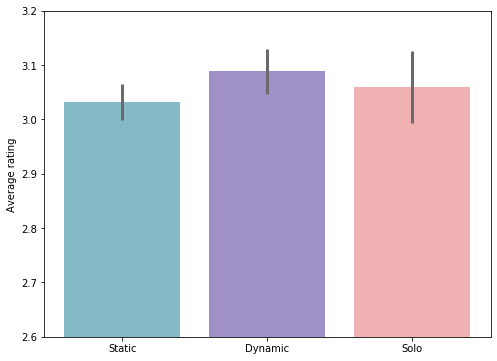


Creativity Quotient

dynamic - crowd
m_1=61.11, m_2=56.9, t(142)=1.41, p=0.16070968431006585,
Bonferroni-corrected (uncorrected p-val * 3) p=0.4821290529301976
95% C.I. for m_1-m_2=[-1.648, 10.080]
 
static - crowd
m_1=58.66, m_2=56.9, t(142)=0.572, p=0.5679086253393526,
Bonferroni-corrected (uncorrected p-val * 3) p=1.7037258760180578
95% C.I. for m_1-m_2=[-4.282, 7.812]
 
dynamic - static
m_1=61.11, m_2=58.66, t(214)=1.224, p=0.22232792550357786,
Bonferroni-corrected (uncorrected p-val * 3) p=0.6669837765107336
95% C.I. for m_1-m_2=[-1.478, 6.381]
 


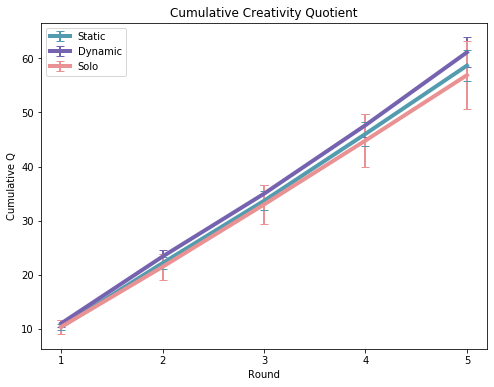

In [40]:
if __name__ == '__main__':
    # load data
    filehandler = open('data/data.obj', 'rb') 
    data_obj = pickle.load(filehandler)
    
    # run analyses
    data_obj.connectivity_update_per_round()
    data_obj.find_popular_alters()
    data_obj.compute_lumped_temporal_boss_vs_lost_uniq()
    data_obj.compute_lumped_boss_vs_lost_ratings()
    data_obj.compute_lumped_temporal_boss_vs_lost_cq()
    data_obj.my_regression("r")
    data_obj.my_regression("ru")
    data_obj.my_regression("all")
    data_obj.my_regression("rq",feature_round=1,output_round=1) #output_round means at the end of that round
    data_obj.my_regression("r",feature_round=1,output_round='final')
    data_obj.stimulation_()
    data_obj.generate_projected_plot("dynamic",True)
    data_obj.compute_similarity_collection(cond_="dynamic")
    data_obj.compute_similarity_collection(cond_="static")
    data_obj.compute_similarity_collection_crowd()
    data_obj.compute_lumped_temporal_cr_vs_st_vs_dy_uniq()
    data_obj.compute_cr_vs_st_vs_dy_rating()
    data_obj.compute_lumped_temporal_cr_vs_st_vs_dy_cq()